In [2]:
%matplotlib inline
import pandas as pd
import scipy as sp
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
country_enc = LabelEncoder()
source_enc = LabelEncoder()
df = pd.DataFrame.from_csv('conversion_data.csv')
df.reset_index(inplace=True)
data_frame = df.copy()
df['country'] = country_enc.fit_transform(df.country)
df['source'] = country_enc.fit_transform(df.source)
df[1:5]

,country,age,new_user,source,total_pages_visited,converted
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


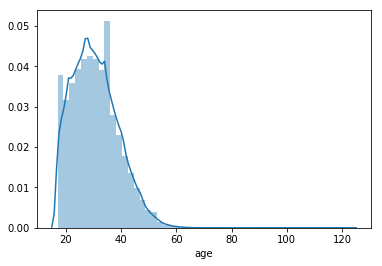

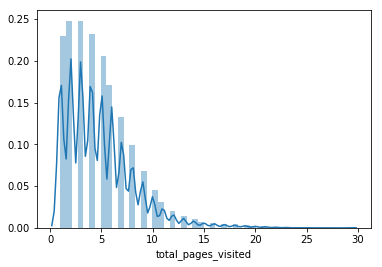

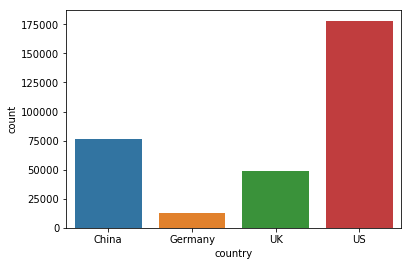

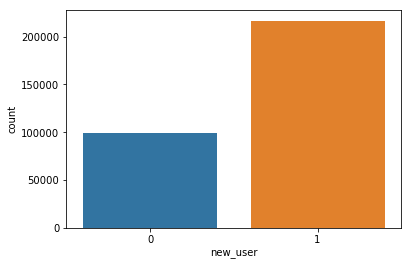

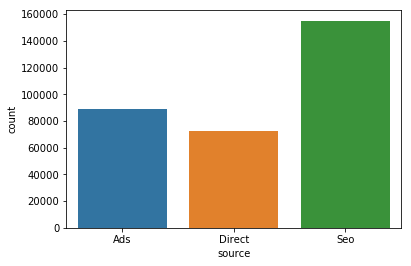

In [4]:
sn.distplot(a=df.age)
plt.show()
sn.distplot(a=df.total_pages_visited)
plt.show()
sn.barplot(x='country', y='count', data=data_frame.groupby('country').count()[['age']].rename(columns={'age':'count'}).reset_index())
plt.show()
sn.barplot(x='new_user', y='count', data=data_frame.groupby('new_user').count()[['age']].rename(columns={'age':'count'}).reset_index())
plt.show()
sn.barplot(x='source', y='count', data=data_frame.groupby('source').count()[['age']].rename(columns={'age':'count'}).reset_index())
plt.show()

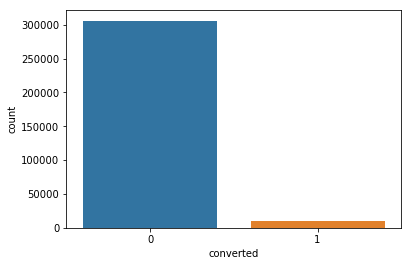

conv rate:  0.0322580645161


,group,group_count,rate,converted
0,nonconverted,306000,0.967742,0
1,converted,10200,0.032258,1


In [5]:
sn.barplot(x='converted', y='count', data=data_frame.groupby('converted').count()[['age']].rename(columns={'age':'count'}).reset_index())
plt.show()
convbool = df.converted == 1
converted = sum(convbool)
non_converted = sum(~convbool)
sessions = len(convbool)
conv_rate = converted / sessions
print("conv rate: ", conv_rate)
stats_df = pd.DataFrame()
stats_df['group'] = ['nonconverted', 'converted']
stats_df['group_count'] = [non_converted, converted]
stats_df['rate'] = stats_df['group_count'] / sessions
stats_df['converted'] = [0, 1]
stats_df

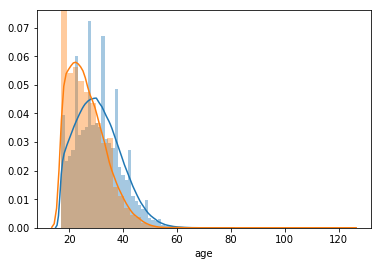

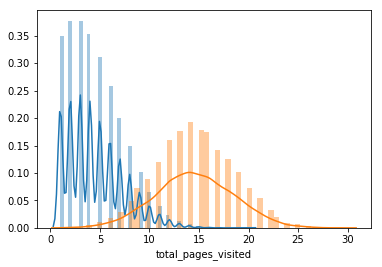

In [6]:
def plot_for_category_numeric_pair(catcol, numcol):
    cats = dict()
    for item in data_frame[catcol].unique():
#         print('for item: ', item, 'in column: ', catcol)
        sn.distplot(a=data_frame.where(data_frame[catcol] == item).dropna(how='all')[numcol])
    plt.show()
plot_for_category_numeric_pair('converted', 'age')
plot_for_category_numeric_pair('converted', 'total_pages_visited')


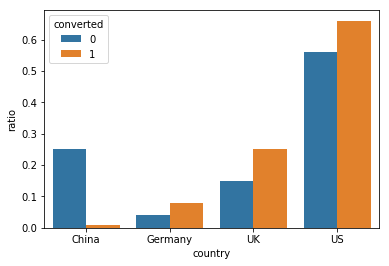

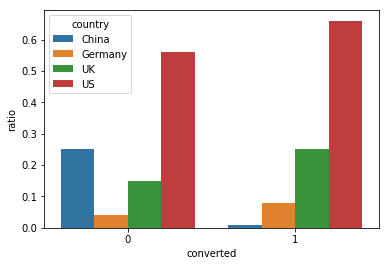

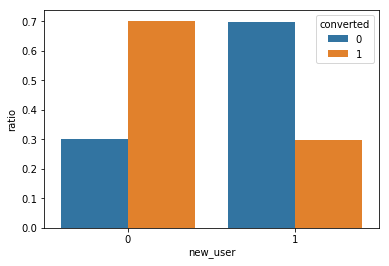

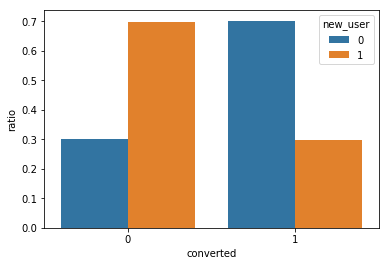

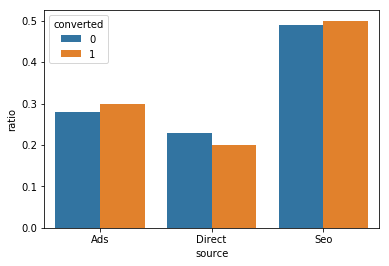

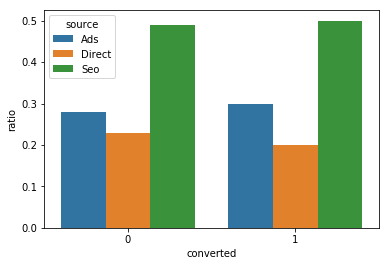

In [7]:
def plot_for_column_pair(col1name, col2name, include_reverse=False):
    plotdf = data_frame.groupby(['converted', col1name, col2name]).count()[['age']].rename(columns={'age':'count'}).reset_index().merge(stats_df[['converted', 'group_count']], on='converted')
    plotdf['ratio'] = plotdf['count'] / plotdf['group_count']
    sn.barplot(x=col1name, y='ratio', data=plotdf, hue=col2name)
    plt.show()
    if include_reverse:
        sn.barplot(x=col2name, y='ratio', data=plotdf, hue=col1name)
        plt.show()
def plot_for_column(colname, include_reverse=False):
    plotdf = data_frame.groupby(['converted', colname]).count()[['age']].rename(columns={'age':'count'}).reset_index().merge(stats_df[['converted', 'group_count']], on='converted')
    plotdf['ratio'] = plotdf['count'] / plotdf['group_count']
    sn.barplot(x=colname, y='ratio', data=plotdf, hue='converted')
    plt.show()
    if include_reverse:
        sn.barplot(x='converted', y='ratio', data=plotdf, hue=colname)
        plt.show()
plot_for_column('country', include_reverse=True)
plot_for_column('new_user', include_reverse=True)
plot_for_column('source', include_reverse=True)

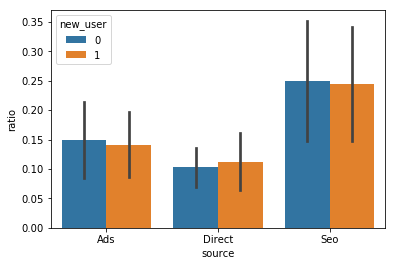

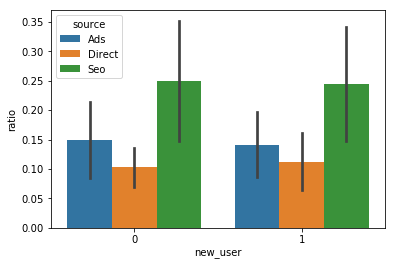

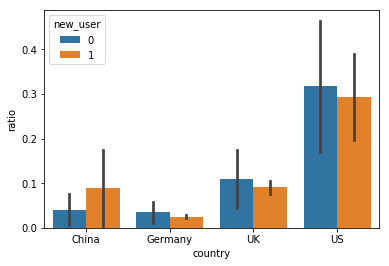

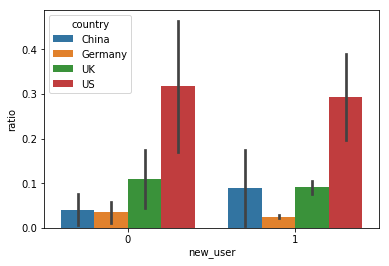

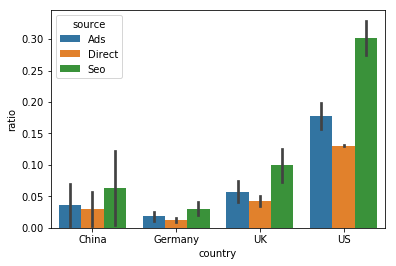

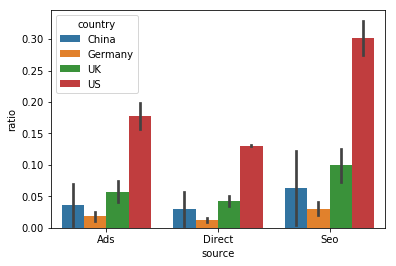

In [8]:
plot_for_column_pair('source','new_user', include_reverse=True)
plot_for_column_pair('country','new_user', include_reverse=True)
plot_for_column_pair('country','source', include_reverse=True)

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')


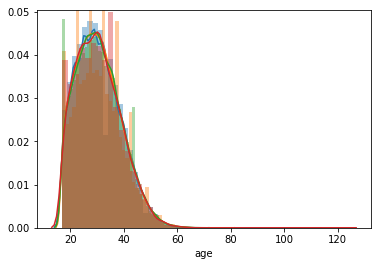

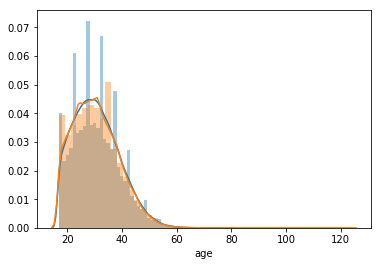

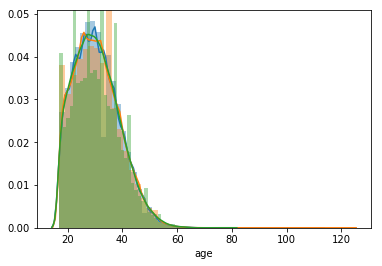

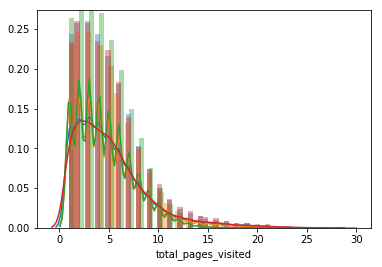

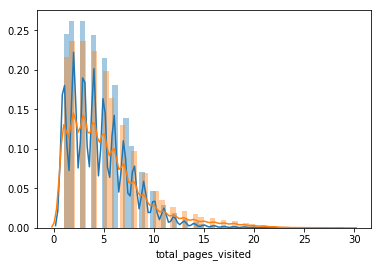

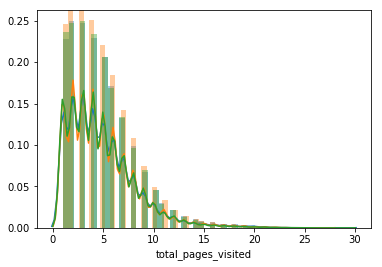

In [9]:
print(data_frame.columns)
plot_for_category_numeric_pair('country', 'age')
plot_for_category_numeric_pair('new_user', 'age')
plot_for_category_numeric_pair('source', 'age')
plot_for_category_numeric_pair('country', 'total_pages_visited')
plot_for_category_numeric_pair('new_user', 'total_pages_visited')
plot_for_category_numeric_pair('source', 'total_pages_visited')

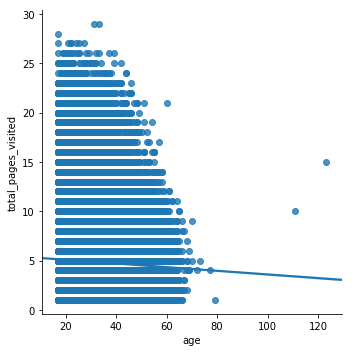

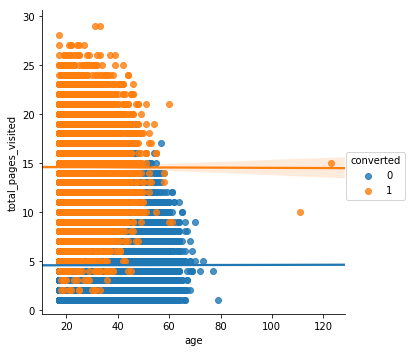

In [10]:
sn.lmplot(x='age', y='total_pages_visited', data=data_frame)
plt.show()
sn.lmplot(x='age', y='total_pages_visited', data=data_frame, hue='converted')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X = pd.get_dummies(data_frame)
del X['converted']
X['age'] = scaler.fit_transform(X[['age']])
X['total_pages_visited'] = scaler.fit_transform(X[['total_pages_visited']])
# X['bias'] = 1
# X['age_mult_page_visits'] = X.age * X.total_pages_visited
# for country in ['China', 'Germany', 'UK', 'US']:
#     for source in ['Ads', 'Direct', 'Seo']:
#         X['country_%s_source_%s' % (country, source)] = X['country_%s' % country] * X['source_%s' % source]
# X['bias'] = 1
Y = data_frame[['converted']]
# X, Y = ohe_df[['country', 'age', 'new_user', 'source', 'total_pages_visited']], df[['converted']]
x_test, x_train, y_test, y_train = train_test_split(X, Y, test_size=0.8, train_size=0.2, stratify=Y['converted'])
X.columns

Index(['age', 'new_user', 'total_pages_visited', 'country_China',
       'country_Germany', 'country_UK', 'country_US', 'source_Ads',
       'source_Direct', 'source_Seo'],
      dtype='object')

In [12]:
from sklearn.preprocessing import LabelBinarizer
prob_enc = LabelBinarizer().fit(y=[0,1])
# prob_enc.inverse_transform(np.asarray([[0.2,0.8]]))

In [52]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

sgd = SGDClassifier(alpha=1e-16, max_iter=300000, tol=1e-45, 
                    loss='modified_huber', 
                    epsilon=1e-4, penalty='elasticnet', 
                    l1_ratio=0.33, class_weight='balanced')
rfor = RandomForestClassifier(n_estimators=50, n_jobs=-1)
dtree = DecisionTreeClassifier()
lindisc = LinearDiscriminantAnalysis()
qdisc = QuadraticDiscriminantAnalysis()

def try_model(clf):
    clf.fit(x_train, y_train.converted)
    train_preds = clf.predict(x_train)
    test_preds = clf.predict(x_test)
    print(classification_report(y_train, train_preds))
    print(classification_report(y_test, test_preds))
    
def try_model_get_proba(clf):
    try_model(clf)
    return clf.predict_proba(x_train), clf.predict_proba(x_test)

print("SGD")
sgd_train_prob, sgd_test_prob = try_model_get_proba(sgd)
print("Rand Forest")
rfor_train_prob, rfor_test_prob = try_model_get_proba(rfor)
print("Decision Tree")
dtree_train_prob, dtree_test_prob = try_model_get_proba(dtree)
print("Linear Discriminant")
lindisc_train_prob, lindisc_test_prob = try_model_get_proba(lindisc)
print("Quadratic Discriminant")
qdisc_train_prob, qdisc_test_prob = try_model_get_proba(qdisc)

SGD
             precision    recall  f1-score   support

          0       1.00      0.88      0.93    244800
          1       0.20      0.95      0.33      8160

avg / total       0.97      0.88      0.91    252960

             precision    recall  f1-score   support

          0       1.00      0.88      0.93     61200
          1       0.21      0.95      0.34      2040

avg / total       0.97      0.88      0.91     63240

Rand Forest
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    244800
          1       0.89      0.73      0.80      8160

avg / total       0.99      0.99      0.99    252960

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     61200
          1       0.82      0.66      0.73      2040

avg / total       0.98      0.98      0.98     63240

Decision Tree
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    244800
   

/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


             precision    recall  f1-score   support

          0       0.99      0.99      0.99    244800
          1       0.74      0.76      0.75      8160

avg / total       0.98      0.98      0.98    252960

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     61200
          1       0.75      0.76      0.75      2040

avg / total       0.98      0.98      0.98     63240

Quadratic Discriminant


/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


             precision    recall  f1-score   support

          0       1.00      0.77      0.87    244800
          1       0.13      0.98      0.22      8160

avg / total       0.97      0.78      0.85    252960

             precision    recall  f1-score   support

          0       1.00      0.78      0.88     61200
          1       0.13      0.97      0.23      2040

avg / total       0.97      0.79      0.85     63240



In [14]:
mlp = MLPClassifier(hidden_layer_sizes=(32,32,32,32,32), activation='tanh')
print("MLP")
mlp_train_prob, mlp_test_prob = try_model_get_proba(mlp)

MLP
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    244800
          1       0.83      0.71      0.77      8160

avg / total       0.99      0.99      0.99    252960

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     61200
          1       0.84      0.70      0.76      2040

avg / total       0.99      0.99      0.99     63240



In [50]:
comb_train_prob = (sgd_train_prob + mlp_train_prob + rfor_train_prob + dtree_train_prob) / 4
comb_test_prob = (sgd_test_prob + mlp_test_prob + rfor_test_prob + dtree_test_prob) / 4
comb_train_preds = prob_enc.inverse_transform(comb_train_prob)
comb_test_preds = prob_enc.inverse_transform(comb_test_prob)
train_prob_sum = sum(comb_train_prob)
test_prob_sum = sum(comb_test_prob)
print('train_rate: ', train_prob_sum[1]/sum(train_prob_sum))
print('test_rate: ', train_prob_sum[1]/sum(train_prob_sum))
print('measured_rate: ', stats_df['rate'][1])

train_rate:  0.0409905996338
test_rate:  0.0409905996338
measured_rate:  0.0322580645161


In [51]:
print(classification_report(y_train, comb_train_preds))
print(classification_report(y_test, comb_test_preds))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99    244800
          1       0.80      0.79      0.80      8160

avg / total       0.99      0.99      0.99    252960

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     61200
          1       0.76      0.75      0.75      2040

avg / total       0.98      0.98      0.98     63240



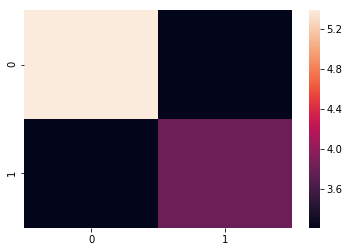

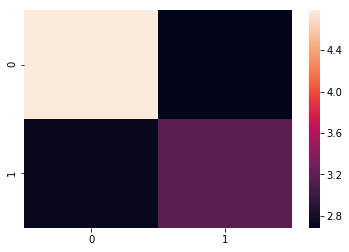

In [17]:
from sklearn.metrics import confusion_matrix
# sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
train_confmat = confusion_matrix(y_train, comb_train_preds)
test_confmat = confusion_matrix(y_test, comb_test_preds)
sn.heatmap(data=np.log10(train_confmat))
plt.show()
sn.heatmap(data=np.log10(test_confmat))
plt.show()

In [56]:
stat_imp_df = pd.DataFrame()
stat_imp_df['feature_name'] = X.columns
stat_imp_df['dtree_feature_importance'] = dtree.feature_importances_
stat_imp_df['rforest_feature_importance'] = rfor.feature_importances_
stat_imp_df['sgd_weights'] = sgd.coef_.ravel()
stat_imp_df['sgd_scaled_weights'] = stat_imp_df['sgd_weights'] / sgd.intercept_[0] * -1
stat_imp_df['linear_disc_weights'] = lindisc.coef_.ravel()
stat_imp_df.set_index('feature_name', inplace=True)

In [57]:
stat_imp_df.sort_values(by=['dtree_feature_importance'], ascending=False)

,dtree_feature_importance,rforest_feature_importance,sgd_weights,sgd_scaled_weights,linear_disc_weights
feature_name,,,,,
total_pages_visited,0.794022,0.807845,1.878599e+06,1.935247,6.189425
age,0.070299,0.110799,1.851386e+05,0.190721,-0.740131
new_user,0.052211,0.040000,-5.160611e+05,-0.531623,-1.891870
country_China,0.040174,0.023679,-1.859999e+06,-1.916086,-0.970227
source_Seo,0.009503,0.002668,-4.953943e+05,-0.510333,0.011069
country_US,0.008520,0.003788,3.106050e+05,0.319971,0.196457
source_Direct,0.007169,0.002654,5.166660e+05,0.532246,-0.105701
country_UK,0.007074,0.003510,2.686665e+05,0.276768,0.678485
source_Ads,0.006673,0.002466,-9.919991e+05,-1.021912,0.078820


In [58]:
stat_imp_df.sort_values(by=['rforest_feature_importance'], ascending=False)

,dtree_feature_importance,rforest_feature_importance,sgd_weights,sgd_scaled_weights,linear_disc_weights
feature_name,,,,,
total_pages_visited,0.794022,0.807845,1.878599e+06,1.935247,6.189425
age,0.070299,0.110799,1.851386e+05,0.190721,-0.740131
new_user,0.052211,0.040000,-5.160611e+05,-0.531623,-1.891870
country_China,0.040174,0.023679,-1.859999e+06,-1.916086,-0.970227
country_US,0.008520,0.003788,3.106050e+05,0.319971,0.196457
country_UK,0.007074,0.003510,2.686665e+05,0.276768,0.678485
source_Seo,0.009503,0.002668,-4.953943e+05,-0.510333,0.011069
source_Direct,0.007169,0.002654,5.166660e+05,0.532246,-0.105701
country_Germany,0.004355,0.002591,3.099998e+05,0.319348,1.013857


In [59]:
stat_imp_df.sort_values(by=['sgd_weights'], ascending=False)

,dtree_feature_importance,rforest_feature_importance,sgd_weights,sgd_scaled_weights,linear_disc_weights
feature_name,,,,,
total_pages_visited,0.794022,0.807845,1.878599e+06,1.935247,6.189425
source_Direct,0.007169,0.002654,5.166660e+05,0.532246,-0.105701
country_US,0.008520,0.003788,3.106050e+05,0.319971,0.196457
country_Germany,0.004355,0.002591,3.099998e+05,0.319348,1.013857
country_UK,0.007074,0.003510,2.686665e+05,0.276768,0.678485
age,0.070299,0.110799,1.851386e+05,0.190721,-0.740131
source_Seo,0.009503,0.002668,-4.953943e+05,-0.510333,0.011069
new_user,0.052211,0.040000,-5.160611e+05,-0.531623,-1.891870
source_Ads,0.006673,0.002466,-9.919991e+05,-1.021912,0.078820


In [60]:
stat_imp_df.sort_values(by=['linear_disc_weights'], ascending=False)

,dtree_feature_importance,rforest_feature_importance,sgd_weights,sgd_scaled_weights,linear_disc_weights
feature_name,,,,,
total_pages_visited,0.794022,0.807845,1.878599e+06,1.935247,6.189425
country_Germany,0.004355,0.002591,3.099998e+05,0.319348,1.013857
country_UK,0.007074,0.003510,2.686665e+05,0.276768,0.678485
country_US,0.008520,0.003788,3.106050e+05,0.319971,0.196457
source_Ads,0.006673,0.002466,-9.919991e+05,-1.021912,0.078820
source_Seo,0.009503,0.002668,-4.953943e+05,-0.510333,0.011069
source_Direct,0.007169,0.002654,5.166660e+05,0.532246,-0.105701
age,0.070299,0.110799,1.851386e+05,0.190721,-0.740131
country_China,0.040174,0.023679,-1.859999e+06,-1.916086,-0.970227


In [22]:
print(sgd.intercept_)

[-6393.13240885]


# Insights from Exploration and Models
- Strong negative effect from chinese market, perhaps actionable
- New users less likely to convert, perhaps thinking about decision, only to come back later and buy
- Strongest feature is total pages visited, which has completely different distribution within converted population
- UK > Germany > US >> China
- Customers don't seem to like the ads very much
- Age is a factor. Users between 20/30 more likely to buy than older users
    - Double down on young users, adjust marketing/ads for more appeal
    - Try changing marketing / ad styles to appeal to older uers